In [149]:
import pandas as pd
import numpy as np
from tsfresh.feature_extraction import extract_features, EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import import_ipynb

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_sample_weight
from tsfresh.feature_selection import select_features
from sklearn.feature_selection import VarianceThreshold

from pyts.transformation import BOSS
from pyts.datasets import load_gunpoint

from catboost import CatBoostClassifier

(50, 150)

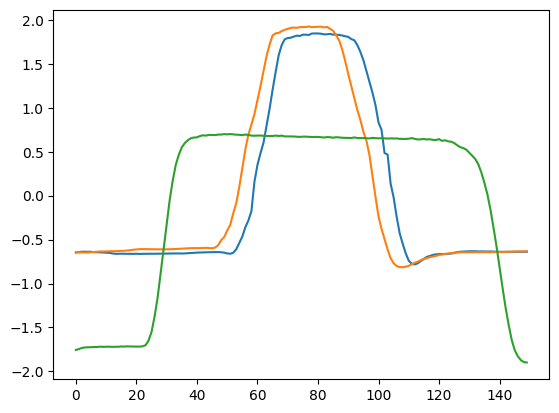

In [2]:
# Toy dataset to understand the shape needed
X_train, _, y_train, _ = load_gunpoint(return_X_y=True)
X_train.shape
plt.plot(X_train[0,:]);
plt.plot(X_train[1,:]);
plt.plot(X_train[23,:]);
X_train.shape

In [3]:
raw_data_prep_dir = '../raw_data/pads-parkinsons-disease-smartwatch-dataset-1.0.0/preprocessed/'

In [4]:
file_list = pd.read_csv(raw_data_prep_dir  + "file_list.csv")
file_list

,resource_type,id,study_id,condition,disease_comment,age_at_diagnosis,age,height,weight,gender,handedness,appearance_in_kinship,appearance_in_first_grade_kinship,effect_of_alcohol_on_tremor,label
0,patient,1,PADS,Healthy,-,56,56,173,78,male,right,True,True,Unknown,0
1,patient,2,PADS,Other Movement Disorders,Left-Sided resting tremor and hypokinesia with...,69,81,193,104,male,right,False,NaN,No effect,2
2,patient,3,PADS,Healthy,-,45,45,170,78,female,right,False,NaN,Unknown,0
3,patient,4,PADS,Parkinson's,IPS akinetic-rigid type,63,67,161,90,female,right,False,NaN,No effect,1
4,patient,5,PADS,Parkinson's,IPS tremordominant type,65,75,172,86,male,left,False,NaN,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464,patient,465,PADS,Parkinson's,IPS mixed type,62,65,175,80,male,right,True,False,No effect,1
465,patient,466,PADS,Healthy,-,84,84,172,74,female,right,True,True,No effect,0
466,patient,467,PADS,Parkinson's,"Essential Tremor, starting IPS tremordominant ...",55,57,190,100,male,right,False,NaN,Improvement,1
467,patient,468,PADS,Parkinson's,IPS mixed type,73,76,198,118,male,right,False,NaN,No effect,1


In [5]:
time_data = []
y = []
X_to_split = []
for idx, subject_idx in enumerate(file_list['id']):
    file_name = raw_data_prep_dir + f'movement/{subject_idx:03d}_ml.bin'
    time_idx_data = np.fromfile(file_name, dtype=np.float32).reshape((-1, 976))
    time_data.append(time_idx_data)
    y_idx = file_list[file_list['id']==subject_idx].label.values
    X_id = idx
    y.append(y_idx)
    X_to_split.append(X_id)

X_to_split = np.array(X_to_split)
y = np.array(y).flatten()
time_data = np.array(time_data)
print(time_data.shape)
time_data.shape[0]
range(time_data.shape[0])

(469, 132, 976)


range(0, 469)

In [96]:
#train test split
X_train_idx, X_test_idx, y_train, y_test = train_test_split(X_to_split, y, test_size=0.20, random_state=23, stratify = y)
X_train = time_data[X_train_idx]
X_test = time_data[X_test_idx]
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))
X_train.shape

375 94
375 94


(375, 132, 976)

In [ ]:
def channel_wise_boss(time_data, word_size = 2, window_size = 30, window_step = 2):
    word_size = word_size
    window_size = window_size
    window_step = window_step
    boss = BOSS(word_size = word_size, window_size = window_size, window_step = window_step)
    boss_output = []
    for c_idx in range(time_data.shape[1]):
        c_data = X_train[:,c_idx,:]
        c_feat = boss.fit(c_data)
        print(c_feat)
        boss_output.append(c_feat)
    return boss_output

In [ ]:
boss_output = channel_wise_boss(X_train, word_size = 4, window_size = 20, window_step = 2)

BOSS(window_size=30, window_step=2, word_size=2)
BOSS(window_size=30, window_step=2, word_size=2)
BOSS(window_size=30, window_step=2, word_size=2)
BOSS(window_size=30, window_step=2, word_size=2)
BOSS(window_size=30, window_step=2, word_size=2)
BOSS(window_size=30, window_step=2, word_size=2)
BOSS(window_size=30, window_step=2, word_size=2)
BOSS(window_size=30, window_step=2, word_size=2)
BOSS(window_size=30, window_step=2, word_size=2)
BOSS(window_size=30, window_step=2, word_size=2)
BOSS(window_size=30, window_step=2, word_size=2)
BOSS(window_size=30, window_step=2, word_size=2)
BOSS(window_size=30, window_step=2, word_size=2)
BOSS(window_size=30, window_step=2, word_size=2)
BOSS(window_size=30, window_step=2, word_size=2)
BOSS(window_size=30, window_step=2, word_size=2)
BOSS(window_size=30, window_step=2, word_size=2)
BOSS(window_size=30, window_step=2, word_size=2)
BOSS(window_size=30, window_step=2, word_size=2)
BOSS(window_size=30, window_step=2, word_size=2)
BOSS(window_size=30,

In [20]:
print(len(boss_output))
boss_output[2]

(X_train[1, 1, :]).reshape(1,-1).shape
len(X_train)

132


375

In [ ]:
def boss_transform_data(boss_output,X):
    boss_output = boss_output
    X = X
    X_boss = []
    for s_idx in range(X.shape[0]):
        for c_idx in range(X.shape[1]):
            channel_boss= boss_output[c_idx]
            boss_features = channel_boss.transform(X[s_idx,c_idx,:].reshape(1,-1))
            X_boss.append(boss_features.toarray())
    print(len(boss_features.toarray()))
    n_feat = len(boss_features.toarray()[0])
    X_boss_reshape = np.array(X_boss).reshape(len(X),X.shape[1]*n_feat)
    return X_boss_reshape

In [188]:
X_boss_train = boss_transform_data(boss_output, X_train)

1


In [186]:
test = boss_output[1].transform(X_train[1,1,:].reshape(1,-1))
len(test.toarray()[0])

16

In [113]:
pd.DataFrame(X_boss_train)

,0,1,2,3,4,5,6,7,8,9,...,2102,2103,2104,2105,2106,2107,2108,2109,2110,2111
0,0,0,0,0,0,44,53,0,0,12,...,14,16,15,17,20,18,12,17,14,16
1,0,1,1,0,0,35,32,1,1,17,...,17,15,7,25,25,17,5,16,10,3
2,0,0,0,0,2,30,26,4,1,26,...,5,14,11,8,7,19,18,18,21,20
3,0,0,0,0,0,49,48,0,0,10,...,27,23,13,15,14,20,5,4,7,6
4,0,0,0,0,0,38,42,0,0,13,...,21,4,3,21,18,3,2,8,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,0,0,0,0,0,48,57,0,0,8,...,24,8,7,25,21,3,6,14,10,4
371,0,0,0,0,0,40,39,0,0,11,...,10,11,14,12,8,5,20,22,14,3
372,0,0,0,0,0,41,42,0,0,11,...,7,13,14,10,10,9,13,18,18,14
373,0,0,0,0,0,30,39,0,0,16,...,21,17,7,22,26,13,14,23,5,0


In [146]:
s_scaler = StandardScaler()
s_scaler.fit(X_boss_train)
X_boss_train_scale = s_scaler.transform(X_boss_train)

In [147]:
xgb = XGBClassifier()

sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

xgb.fit(X_boss_train, y_train, sample_weight=sample_weights)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [148]:
X_boss_test = boss_transform_data(boss_output, X_test)
X_boss_test_scaled = s_scaler.transform(X_boss_test)

In [162]:
y_pred_xgb  = xgb.predict(X_boss_test)

In [163]:
xgb_accuracy = balanced_accuracy_score(y_test, y_pred)
f'xgb_accuracy: {xgb_accuracy}'

'xgb_accuracy: 0.5819499341238471'

In [164]:
cat_model = CatBoostClassifier(iterations = 2000, learning_rate = 0.05,depth = 7)

In [165]:
cat_model.fit(X_boss_train, y_train, sample_weight=sample_weights)

0:	learn: 1.0862984	total: 114ms	remaining: 3m 48s
1:	learn: 1.0734223	total: 185ms	remaining: 3m 5s
2:	learn: 1.0628235	total: 218ms	remaining: 2m 25s
3:	learn: 1.0513913	total: 248ms	remaining: 2m 3s
4:	learn: 1.0408940	total: 281ms	remaining: 1m 52s
5:	learn: 1.0321613	total: 310ms	remaining: 1m 42s
6:	learn: 1.0217211	total: 339ms	remaining: 1m 36s
7:	learn: 1.0096630	total: 371ms	remaining: 1m 32s
8:	learn: 0.9978982	total: 403ms	remaining: 1m 29s
9:	learn: 0.9886037	total: 435ms	remaining: 1m 26s
10:	learn: 0.9781450	total: 465ms	remaining: 1m 24s
11:	learn: 0.9708186	total: 494ms	remaining: 1m 21s
12:	learn: 0.9621960	total: 523ms	remaining: 1m 19s
13:	learn: 0.9517212	total: 556ms	remaining: 1m 18s
14:	learn: 0.9429941	total: 590ms	remaining: 1m 18s
15:	learn: 0.9365484	total: 621ms	remaining: 1m 17s
16:	learn: 0.9303570	total: 652ms	remaining: 1m 16s
17:	learn: 0.9237056	total: 686ms	remaining: 1m 15s
18:	learn: 0.9133963	total: 717ms	remaining: 1m 14s
19:	learn: 0.9056776	tot

In [156]:
y_pred_cat = cat_model.predict(X_boss_test)

In [159]:
cat_accuracy = balanced_accuracy_score(y_pred_cat,y_test)
f'cat_accuracy: {cat_accuracy}'

'cat_accuracy: 0.6241830065359477'